<a href="https://colab.research.google.com/github/Lynnluxu/style-transfer/blob/master/Neural_Style_Transfer_Lille_images_v2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Style Transfer with Lille images using Pytorch**
---






Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components

## **Mount google drive firstly**
---

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Install requirements**
---

In [2]:
!pip install -r "/content/drive/My Drive/resources/requirements.txt"

  Cloning https://github.com/bleshik/instaloader.git to /tmp/pip-req-build-urm0zt6_
  Running command git clone -q https://github.com/bleshik/instaloader.git /tmp/pip-req-build-urm0zt6_
  Created wheel for instaloader: filename=instaloader-4.2.6-cp36-none-any.whl size=41606 sha256=fd7bb1d53ffebd17005abe88a0186e9002f5c0e135a11ad8aeee39d976686120
  Stored in directory: /tmp/pip-ephem-wheel-cache-hstladb3/wheels/6b/99/f9/f37a7414fbe8f3b65e10fff1997066aa80618578a9e0ba3687
Successfully built instaloader


## **Import libraries**
---

In [0]:
# import resources
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np

from instaloader import Instaloader, Profile
from fastai.vision import *
from pathlib import Path
import itertools

import torch
import torch.optim as optim
from torchvision import *
import torch.nn.functional as F
import random

from PIL import Image


## **Download Lille images (content)**









In [0]:
# Get current directory
content_path = Path('drive/My Drive/data/content/')
content_folder = "dataset_lille_images"
txt_file_name = "lille_images_urls.txt"

# Create the directories to store the images
os.makedirs(content_path/content_folder, exist_ok=True)

Get URLs images of instagram posts using instaloader library and write them into a txt file

In [0]:
loader = Instaloader(download_videos=False,
                 download_video_thumbnails=False,
                 download_geotags=False,
                 download_comments=False,
                 save_metadata=False,
                 compress_json=False,)

profile_name = "lillemaville"
profile = Profile.from_username(loader.context, profile_name)

In [0]:
NB_IMAGES_TO_DOWNLOAD = 50
file = open(content_path/txt_file_name, 'w')

for post in itertools.islice(profile.get_posts(), NB_IMAGES_TO_DOWNLOAD):
    file.write("%s\n" % post.url)
    
file.close()

Download the retrieved images with Fastai

In [7]:
path_content_imgs = content_path/content_folder

print("Downloading Lille Images...")
download_images(urls=content_path/txt_file_name, dest=path_content_imgs)

# verify images have correct properties for training
print("Delete Corrupted Images...")
verify_images(path_content_imgs, delete=True, img_format=f'{content_folder} %d')

Delete Corrupted Images...


## **Data exploration** - Looking at the data...
---

In [0]:
path_content_imgs = f"drive/My Drive/data/content/{content_folder}"
path_style_imgs = "drive/My Drive/data/style/"

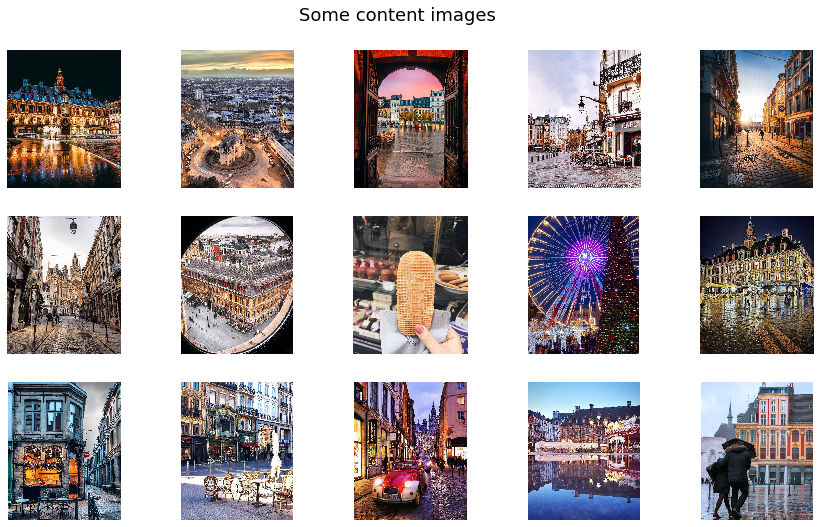

In [9]:
fnames = get_image_files(path_content_imgs)

plt.figure(figsize=(15,30))
plt.suptitle("Some content images", fontsize=18, y = 0.9)
for i in range(15):
    plt.subplot(10,5,i+1)
    plt.axis('off')
    data = plt.imread(str(fnames[i]))
    plt.imshow(data)


 **Helpers functions for images**
---

In [0]:
def load_image(img_path, max_size=400, shape=None):
  """
  Helper function to convert images to normalized Tensors
  """
    
  image = Image.open(img_path).convert('RGB')
  
  # large images will slow down processing
  if max(image.size) > max_size:
      size = max_size
  else:
      size = max(image.size)
  
  if shape is not None:
      size = shape
      
  in_transform = transforms.Compose([
                      transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.485, 0.456, 0.406), 
                                            (0.229, 0.224, 0.225))])
  image = in_transform(image)[:3,:,:].unsqueeze(0)

  return image

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
  """ 
  Helper function for un-normalizing an image 
  and converting it from a Tensor image to a NumPy image for display
  """
  
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

## **Create Dataset and Data Loader**
---

In [0]:
class ImagesDataset():
    def __init__(self, folder_path): 
      self.folder_path = folder_path
      self.fnames = get_image_files(self.folder_path)
      self.fnames = sorted(self.fnames, key=lambda x: random.random())

    def __len__(self): 
      return len(self.fnames)

    def __getitem__(self, i): 
      return load_image(self.fnames[i]).to(device), os.path.basename(self.fnames[i]).split(".")[0]

In [0]:
class Dataloader():
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        for i in range(0, len(self.dataset)):
            yield self.dataset[i]

## **Importing the model** 
---

VGG19 is split into two portions:

* vgg19.features, which are all the convolutional and pooling layers
* vgg19.classifier, which are the three linear, classifier layers at the end

We only need the features portion, which we're going to load in and "freeze" the weights of, below.

Below, we also have the option to weight the style representation at each relevant layer. It's suggested to use a range between 0-1 to weight these layers. By weighting earlier layers (conv1_1 and conv2_1) more, we can expect to get larger style artifacts in the target image :

In [0]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        # Load VGG Skeleton (only convolutional and pooling layers)
        self.features = models.vgg19(pretrained=True).features

        # Freeze all VGG parameters
        for param in self.features.parameters():
            param.requires_grad = False
        
        # weights for each style layer 
        # weighting earlier layers more will result in *larger* style artifacts
        self.style_layers_weights = {'conv1_1': 1.,
                        'conv2_1': 0.75,
                        'conv3_1': 0.2,
                        'conv4_1': 0.2,
                        'conv5_1': 0.2}

        self.content_layer = 'conv4_2'

    def forward(self, x):
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', ## content representation
                  '28': 'conv5_1'}

        features = {}
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x

        return features

## **Making style transfer**
---

### Gram matrix

The Gram matrix of a convolutional layer can be calculated as follows:

* Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

In [0]:
def gram_matrix(tensor):
    # get the batch_size, depth, height, and width of the Tensor
    bs, d, h, w = tensor.size()
   
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(bs * d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    return gram

### Weights for style transfer

Just like in the article, we define an alpha (content_weight) and a beta (style_weight). This ratio will affect how stylized the final image is. It's recommended to leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [0]:
content_weight = 1  # alpha
style_weight = 1e9  # beta

### Style transfer function

To get the content and style representations of an image, we have to pass an image forward throug the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [0]:
def making_style_transfer(model, content, style, nb_epochs, log_frequency):
  target = content.clone().requires_grad_(True).to(device)

  # loss and optimizer
  mse_loss = nn.MSELoss()
  optimizer = optim.Adam([target], lr=0.003)


  # get the content and style features
  content_features = model(content)
  style_features = model(style)

  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  for i in range(nb_epochs):
    # get the features from the target image
    target_features = model(target)

    # the content loss
    content_loss = mse_loss(target_features[model.content_layer], content_features[model.content_layer])
    
    # the style loss - initialize it to 0
    style_loss = 0.0  

    # then add to it for each layer's gram matrix loss
    for layer in model.style_layers_weights:
        
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        bs, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        
        # get the "style" style representation
        style_gram = style_grams[layer]
        
        # the style loss for one layer, weighted appropriately
        layer_style_loss = model.style_layers_weights[layer] * mse_loss(target_gram, style_gram)
        
        # add to the style loss
        style_loss += layer_style_loss / (bs * d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % log_frequency == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

  return(target)

## **Main program**
---

In [20]:
content_data = ImagesDataset(path_content_imgs)
content_dataloader = DataLoader(content_data)
print(f"Number of Lille images: {len(content_dataloader.dataset)}")

Number of Lille images: 50


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG19().to(device) # Move the model to GPU, if available

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


We have to decide on a number of steps for which to update the image. We recommend to use at least 2000 steps for good results. 

==== NEW CONTENT IMAGE ====
==== NEW STYLE IMAGE ====
Total loss:  5726400413696.0


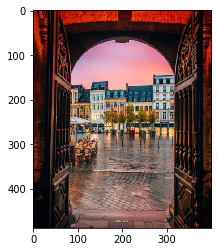

KeyboardInterrupt: ignored

In [22]:
style_images = get_image_files(path_style_imgs)

NB_CONTENT_IMAGES = 1
EPOCHS = 2000  
LOG_FREQUENCY = 1000

# Create the directories to store the images
results_path = "drive/My Drive/data/results/"
os.makedirs(results_path, exist_ok=True)

for content, fname in itertools.islice(content_dataloader.dataset, NB_CONTENT_IMAGES):
  print("==== NEW CONTENT IMAGE ====")
  os.makedirs(f"{results_path}/{fname}", exist_ok=True)
  plt.imsave(f"{results_path}/{fname}/{fname}.jpg", im_convert(content), dpi = 600)

  for style_img in style_images:
    print("==== NEW STYLE IMAGE ====")
    style = load_image(str(style_img), shape=content.shape[-2:]).to(device)
    target = making_style_transfer(model, content, style, nb_epochs=EPOCHS, log_frequency=LOG_FREQUENCY)

    style_fname = os.path.basename(style_img).split(".")[0]
    target_fname = f"{style_fname}_{fname}"
    
    plt.imsave(f"{results_path}/{fname}/{target_fname}.jpg", im_convert(target), dpi = 600)